In [1]:
#import required classes and packages
import os
import cv2
import numpy as np
from keras.utils import to_categorical
from keras.layers import MaxPool2D
from keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Conv2D
from keras.models import Sequential, load_model, Model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG19
from keras.applications import Xception
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
#define and load class labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())   
print("Skin Lesion Class Labels : "+str(labels))  

Skin Lesion Class Labels : ['malignant', 'benign']


In [3]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [4]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images
                img = cv2.resize(img, (128, 128))#resize image
                X.append(img) #add image pixels to X array
                label = getLabel(name)#get image label id
                Y.append(label)#add image label                
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

Dataset images loaded
Total images found in dataset : 11396



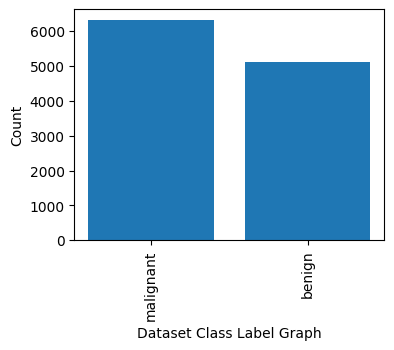

In [5]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (4, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Sample Processed Image')

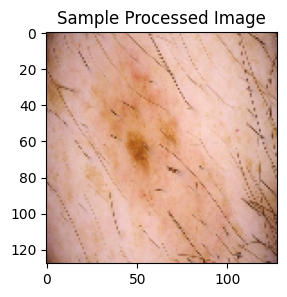

In [6]:
#display processed sample image
img = X[120]
plt.figure(figsize =(4, 3)) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Processed Image")

In [7]:
#preprocess images like shuffling and normalization
X1 = []
Y1 = []
count = 0 
for i in range(len(X)):
    if Y[i] == 0 and count < 1000:
        X1.append(X[i])
        Y1.append(Y[i])  
        count += 1   
count = 0 
for i in range(len(X)):
    if Y[i] == 1 and count < 1000:
        X1.append(X[i])
        Y1.append(Y[i])  
        count += 1  
X = np.asarray(X1)
Y = np.asarray(Y1)
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : "+str(X_train.shape[0]))
print("20% image used to train algorithms : "+str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 1600
20% image used to train algorithms : 400


In [8]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [9]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    global labels
    global accuracy, precision, recall, fscore
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    fig, axs = plt.subplots(1,2,figsize=(10, 3))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
    ax.set_ylim([0,len(labels)])
    axs[0].set_title(algorithm+" Confusion matrix") 

    random_probs = [0 for i in range(len(testY))]
    p_fpr, p_tpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
    ns_fpr, ns_tpr, _ = roc_curve(testY, predict, pos_label=1)
    axs[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Predicted Classes')
    axs[1].set_title(algorithm+" ROC AUC Curve")
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive rate')
    plt.tight_layout()
    plt.show()    

2024-08-26 15:23:27.749114: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x30424b640 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-08-26 15:23:27.749127: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-08-26 15:23:27.776001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-26 15:23:28.090047: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-08-26 15:23:28.091011: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
VGG19 Accuracy  : 93.5
VGG19 Precision : 93.56302816018456
VGG19 Recall    : 93.45841150719198
VGG19 FSCORE    : 93.48958333333333


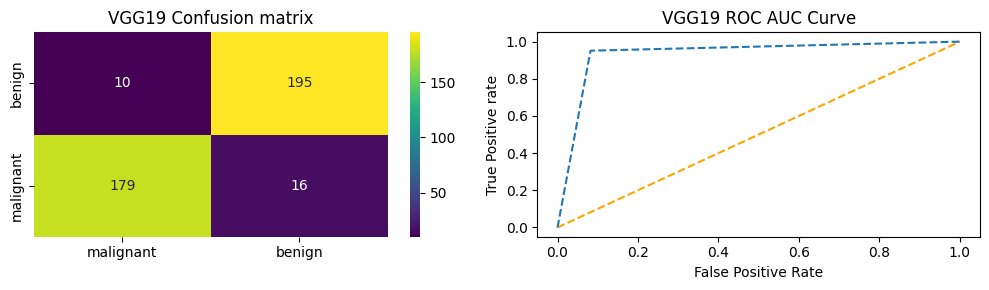

In [10]:
#loading pree-defined vgg19 model
vgg = VGG19(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in vgg.layers:
  layer.trainable = False
#modifying vgg architecture to train on custom skin dataset    
headModel = vgg.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(y_train.shape[1], activation="softmax")(headModel)
vgg_model = Model(inputs=vgg.input, outputs=headModel)
#compile train and load model
vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/vgg_weights.keras") == False:
  #defining    
  param_grid = {'optimizer__learning_rate': [0.0001, 0.001, 0.01], 'optimizer': ['adam', 'sgd', 'Adagrad']}
  model_check_point = ModelCheckpoint(filepath='model/vgg_weights.keras', verbose = 1,
                                      save_best_only = True)  
  vgg_tune_model = KerasClassifier(build_fn=vgg_model, epochs=15, batch_size=32, callbacks=[model_check_point],
                                  verbose=1)
  grid_search = GridSearchCV(estimator=vgg_tune_model, param_grid=param_grid, cv=3)
  grid_search.fit(X_train, y_train, validation_data=(X_test, y_test))
  f = open('model/vgg_best.pckl', 'wb')
  pickle.dump(grid_search, f) 
  f.close() 
else:
  vgg_model = load_model("model/vgg_weights.keras")
#performing prediction on test data    
predict = vgg_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#calculating accuracy and other metrics using test data
calculateMetrics("VGG19", y_test1, predict)

13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step
Xception Accuracy  : 85.5
Xception Precision : 85.6766719325961
Xception Recall    : 85.59099437148218
Xception FSCORE    : 85.4967367657723


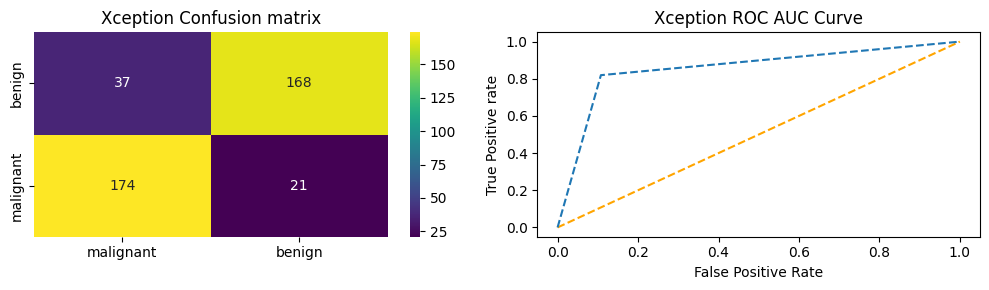

In [11]:
#training and evaluating performance of Xception model
xception = Xception(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in xception.layers:
  layer.trainable = False
headModel = xception.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(y_train.shape[1], activation="softmax")(headModel)
xception_model = Model(inputs=xception.input, outputs=headModel)
xception_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/xception_weights.keras") == False:
  param_grid = {'optimizer__learning_rate': [0.0001, 0.001, 0.01], 'optimizer': ['adam', 'sgd', 'Adagrad']}
  model_check_point = ModelCheckpoint(filepath='model/xception_weights.keras', verbose = 1,
                                      save_best_only = True)
  xception_tune_model = KerasClassifier(build_fn=xception_model, epochs=3, batch_size=32, callbacks=[model_check_point],
                                  verbose=1)
  grid_search = GridSearchCV(estimator=xception_tune_model, param_grid=param_grid, cv=3)
  grid_search.fit(X_train, y_train, validation_data=(X_test, y_test))
  f = open('model/xception_best.pckl', 'wb')
  pickle.dump(grid_search, f)
  f.close()
else:
  xception_model = load_model("model/xception_weights.keras")
#performing prediction on test data     
predict = xception_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#calculating accuracy and other metrics using test data
calculateMetrics("Xception", y_test1, predict)

/Users/srijayketavarapu/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step
Alexnet Accuracy  : 85.75
Alexnet Precision : 85.90225563909775
Alexnet Recall    : 85.83489681050656
Alexnet FSCORE    : 85.74777308954525


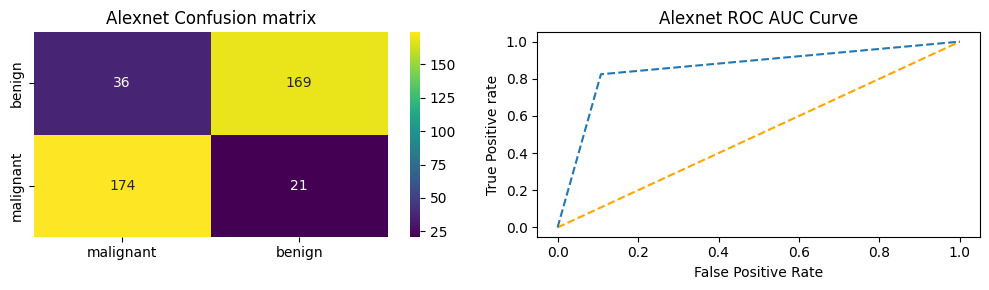

In [12]:
#training AlexNet model
alexnet_model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])),
    BatchNormalization(),
    MaxPool2D(pool_size=(1,1), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(9,9), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(1,1), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(7,7), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(1,1), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(6,6), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(1,1), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(1,1), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(1,1), strides=(2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(y_train.shape[1], activation='softmax')
])
alexnet_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])#compiling the model
if os.path.exists("model/alexnet_weights.keras") == False:
  param_grid = {'optimizer__learning_rate': [0.0001, 0.001, 0.01], 'optimizer': ['adam', 'sgd', 'Adagrad']}
  model_check_point = ModelCheckpoint(filepath='model/alexnet_weights.keras', verbose = 1,
                                      save_best_only = True)
  alexnet_tune_model = KerasClassifier(build_fn=alexnet_model, epochs=5, batch_size=32, callbacks=[model_check_point],
                                  verbose=1)
  grid_search = GridSearchCV(estimator=alexnet_tune_model, param_grid=param_grid, cv=3)
  grid_search.fit(X_train, y_train, validation_data=(X_test, y_test))
  f = open('model/alexnet_best.pckl', 'wb')
  pickle.dump(grid_search, f)
  f.close()
else:
  alexnet_model = load_model("model/alexnet_weights.keras")
#performing prediction on test data     
predict = alexnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#calculating accuracy and other metrics using test data
calculateMetrics("Alexnet", y_test1, predict)

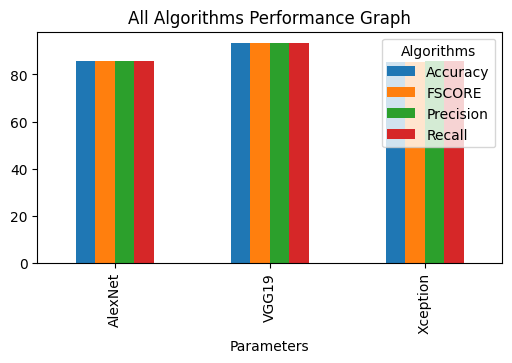

In [13]:
#plot all algorithm performance in tabukar format
import pandas as pd
df = pd.DataFrame([['VGG19','Accuracy',accuracy[0]],['VGG19','Precision',precision[0]],['VGG19','Recall',recall[0]],['VGG19','FSCORE',fscore[0]],
                   ['Xception','Accuracy',accuracy[1]],['Xception','Precision',precision[1]],['Xception','Recall',recall[1]],['Xception','FSCORE',fscore[1]],
                   ['AlexNet','Accuracy',accuracy[2]],['AlexNet','Precision',precision[2]],['AlexNet','Recall',recall[2]],['AlexNet','FSCORE',fscore[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot(index="Parameters", columns="Algorithms", values="Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [14]:
#display all algorithm performnace
algorithms = ['VGG19', 'Xception', 'AlexNet']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data   

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,VGG19,93.50,93.563028,93.458412,93.489583
1,Xception,85.50,85.676672,85.590994,85.496737
2,AlexNet,85.75,85.902256,85.834897,85.747773


In [64]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (128,128))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,128,128,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    pred = vgg_model.predict(img)#now predict type of skin lesion
    predict = np.argmax(pred)
    score = np.amax(pred)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted : '+labels[predict]+" Score : "+str(score), (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


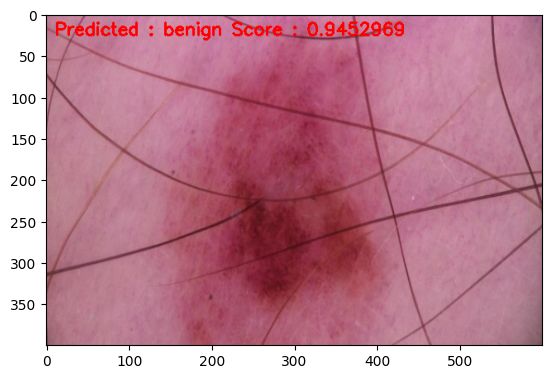

In [65]:
#call this function with input image path to predict skin lesion type
predict("testImages/0.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


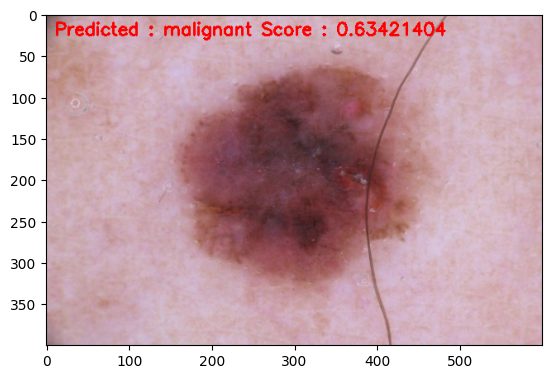

In [66]:
#call this function with input image path to predict skin lesion type
predict("testImages/1.jpg")